# Reading and writing fields

There are three file formats to which a `discretisedfield.Field` object can be saved:

- [VTK](https://vtk.org/) for visualisation using e.g., [ParaView](https://www.paraview.org/) or [Mayavi](https://docs.enthought.com/mayavi/mayavi/)
- OOMMF [Vector Field File Format (OVF)](https://math.nist.gov/oommf/doc/userguide12a5/userguide/Vector_Field_File_Format_OV.html) for exchanging fields with micromagnetic simulators.
- HDF5

Let us say we have a nanosphere sample:

$$x^2 + y^2 + z^2 <= r^2$$

with $r=5\,\text{nm}$. The space is discretised into cells with dimensions $(0.5\,\text{nm}, 0.5\,\text{nm}, 0.5\,\text{nm})$. The value of the field at $(x, y, z)$ point is $(-cy, cx, cz)$, with $c=10^{9}$. The norm of the field inside the cylinder is $10^{6}$.

Let us first build that field.

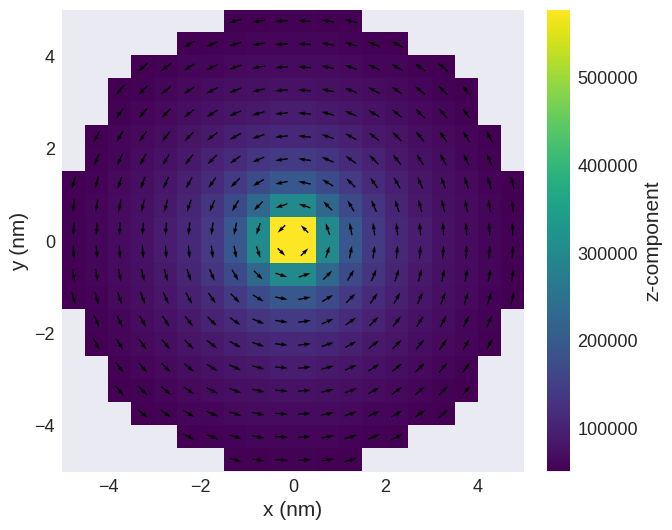

In [1]:
import discretisedfield as df

r = 5e-9
cell = (0.5e-9, 0.5e-9, 0.5e-9)

mesh = df.Mesh(p1=(-r, -r, -r), p2=(r, r, r), cell=cell)


def norm_fun(pos):
    x, y, z = pos
    if x**2 + y**2 + z**2 <= r**2:
        return 1e6
    else:
        return 0


def value_fun(pos):
    x, y, z = pos
    c = 1e9
    return (-c * y, c * x, c * z)


field = df.Field(mesh, nvdim=3, value=value_fun, norm=norm_fun, valid="norm")
field.sel("z").mpl()

## Writing the field to a file

The main method used for saving fields in different files is `discretisedfield.Field.to_file()`. It takes `filename` as an argument, which is a string with one of the following extensions:
- `'.vtk'` for saving in the VTK format
- `'.ovf'`, `'.omf'`, `'.ohf'` for saving in the OVF format
- `'.h5'` or `'.hdf5'` for saving and HDF5 file

Let us firstly save the field in the VTK file format. There are three different possible representations: `bin`, `txt` and `xml`. Refer to the VTK documentation for details. By default, VTK files in `discretisedfield` are saved as `bin`.

In [2]:
vtkfilename = "my_vtk_file.vtk"
field.to_file(vtkfilename)

We can check if the file was saved in the current directory.

In [3]:
import os

os.path.isfile(f"./{vtkfilename}")

True

Now, we can delete the file:

In [4]:
os.remove(f"./{vtkfilename}")

Next, we can save the field in the OVF format and check whether it was created in the current directory.

In [5]:
omffilename = "my_omf_file.omf"
field.to_file(omffilename)
os.path.isfile(f"./{omffilename}")

True

There are three different possible representations of an OVF file: one ASCII (`txt`) and two binary (`bin4` or `bin8`). Binary `bin8` representation is the default representation when `discretisedfield.Field.to_file()` is called. If a different representation is required, it can be passed via `representation` argument.

In [6]:
field.to_file(omffilename, representation="bin4")
os.path.isfile(f"./{omffilename}")

True

In the same way, we can save the HDF5 file:

In [7]:
hdf5filename = "my_omf_file.hdf5"
field.to_file(hdf5filename)
os.path.isfile(f"./{hdf5filename}")

True

## Reading files

The method for reading OVF files is a class method `discretisedfield.Field.from_file()`. By passing a `filename` argument, it reads the file and creates a `discretisedfield.Field` object. It is not required to pass the representation of the OVF and the VTK file to the `discretisedfield.Field.from_file()` method, because it can retrieve it from the content of the file.

In [8]:
read_field = df.Field.from_file(omffilename)

Like previouly, we can quickly visualise the field

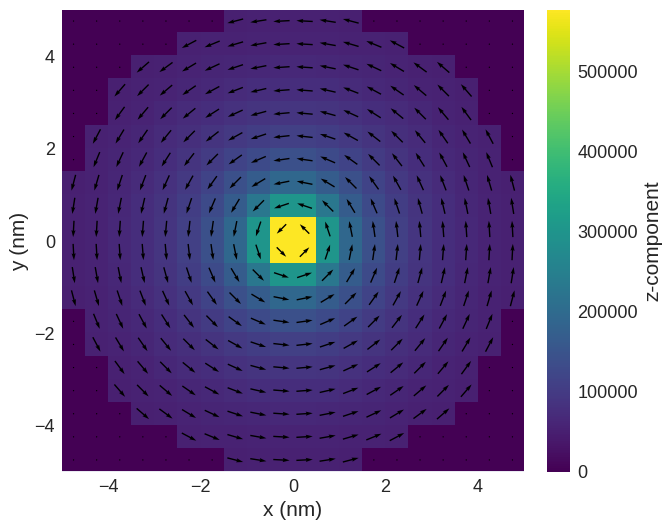

In [9]:
read_field.sel("z").mpl()

We can see that the OVF (and VTK) file cannot store the `valid` array and hence this data is lost.

In HDF5 files, we have more freedom and can also store the valid information.

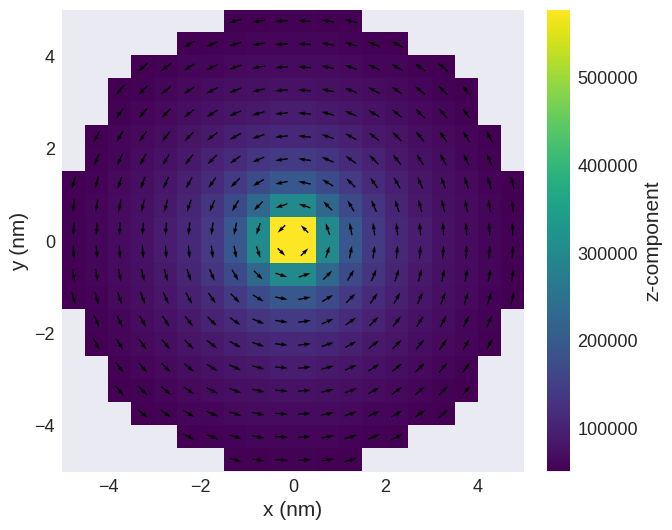

In [10]:
read_file = df.Field.from_file(hdf5filename)
read_file.sel("z").mpl()

Finally, we can delete the OVF and HDF5 file we created.

In [11]:
os.remove(f"./{omffilename}")

In [12]:
os.remove(f"./{hdf5filename}")

## Subregions

If we define subregions on the mesh, they are stored as follows:

- For OVF and VTK we save an additional json file that contains the subregion information. If we save the field to `our_field.vtk` the subregion information is stored as `our_field.vtk.subregions.json`. When reading a file, `discretisedfield` automatically checks if there is an additional subregion json file and loads the additional data from there.  
*Note: Be careful to remove old subregion json files if you overwrite an existing file on disk where the field had subregions with a new field that does not have subregions. Otherwise, reading will potentially fail because the old subregions are incompatible with the new mesh.*

- The HDF5 file directly contains all subregion information and no additional file is required. For more details about its format, please refer to our [HDF5 specification](https://ubermag.github.io/documentation/notebooks/ubermag/hdf5-file-specification.html).